# Solving a Drift-Diffusion model via a Weighted Spectral Method in Julia

In this notebook I'll go through solving and visualizing results of a system of differential equations meant to model solute dispersion in long pipes or channels. 

The system in question is from [this paper](https://math.bu.edu/people/cew/preprints/BCW_Taylor_Model.pdf), and is meant to be easier to solve and analyze compared to the full drift-diffusion equation:

\begin{eqnarray}
\large
u_t = \nu \Delta u - V(y,z) u_x.
\end{eqnarray}

Here the concentration is $u(x,y,z,t)$, and the variable $x$ is unbounded. The Diffusivity $\nu > 0$ is small. We interpret the terms on the right-hand side as the simultaneous action of diffusion and transport: 

<center><img src="pipeIcCrop.gif"></center>

We can see that a small blob of dye or solute initially moves along with the flow in the pipe, but also diffuses slowly out towards the pipe walls. Eventually, however, the effective behavior is quite different: it diffuses *rapidly* down the length of the pipe. In fact, it effectively obeys this equation:

\begin{eqnarray}
\large
\bar{u}_t = \nu_T \bar{u}_{xx}
\end{eqnarray}

 Here $\nu_T = \mathcal{O}(\nu^{-1})$ which is a large diffusion coefficient indicating rapid diffusion:
<center><img src="effIc.gif"></center>
In this visualization, two things are noteworthy: (1) the scale has been adjusted to make the behavior more easily observable, and (2) we are now moving along with the pipe flow.

This effective behavior (and corrective terms) can be obtained by solving the following system of ODEs, which are derived in the above paper from a spectral decomposition corresponding to an enhanced diffusion operator in a weighted $L^2$ space (see paper for details.):

\begin{eqnarray}
\alpha_k' & = & -\frac{k}{2} \alpha_k - \beta_{k-1} - \frac{1}{\nu}\alpha_{k-2} \\
\beta_k' & = & \left(-\frac{k}{2} + \frac{1}{2}\right) \beta_k - \frac{1}{\nu}\beta_{k-2} - e^{\tau}\left( \nu \beta_k + \alpha_{k-1} \right)
\end{eqnarray}
for $k = 2, \ldots, N$ and 
\begin{eqnarray}
\alpha_0' & = & 0 \\
\beta_0' & = & \frac{1}{2} \beta_0 - \nu e^{\tau} \beta_0 \\
\alpha_1' & = & -\frac{1}{2} \alpha_1 \\
\beta_1' & = & -\nu e^{\tau} \beta_1
\end{eqnarray}

Here the $\alpha_k$ indicate modes of cross-stream average with spatial granularity increasing with $k$, and
similarly, the $\beta_k$ indicate modes deviating from cross-stream average with spatial granularity increasing with $k$.

We'll proceed by importing packages and calculating initial conditions related to the spectral method:

## Importing Packages and setting initial conditions

We'll be using some tools from Julia for solving differential equations, as well as `MathLink` and some file IO to communicate with Wolfram Mathematica. In this case Mathematica does a better job of calculating some integrals associated with initializing the spectral method than Julia does.

In [1]:
using MathLink, ModelingToolkit, LinearAlgebra, DifferentialEquations, DelimitedFiles, Plots, ColorSchemes
include("herms2.jl");

In [98]:
numBlobs = 1;
xMax = 10;
tMax = 10.0;
ν0=0.1;
XMax = xMax*ν0;
TMax = tMax*ν0;
g(x) =(1/(sqrt(4*π)))*exp(-x^2/4);
randScale = 2*(.2 .+rand(Float64, numBlobs))
randShift = 10*(rand(Float64,numBlobs).-.5)
H(x) =sum([eval(g(randScale[k]*(x-randShift[k]))) for k in 1:numBlobs])
h(x) = H(x/ν0);
randOffst = rand(Float64, 2);
f(x,y) = H(x)*(randOffst[1] + randOffst[2]*cos(y))
default(legend = false)
l = 2*xMax;
dl = 0.01;
w = π;
nw = 20;
dw = w/nw;
x=-l:dl:l;
y=-w:dw:w;
adjRandScale = ν0.*randScale;
adjRandShift = ν0.*randShift;

## Visualizing Initial conditions
The above code block sets our domain size, time scales, and a random localized initial condition. Let's see what that looks like when injected into the pipe:

┌ Info: Saved animation to 
│   fn = C:\Users\illes\code\tmp.gif
└ @ Plots C:\Users\illes\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\illes\\code\\tmp.gif")
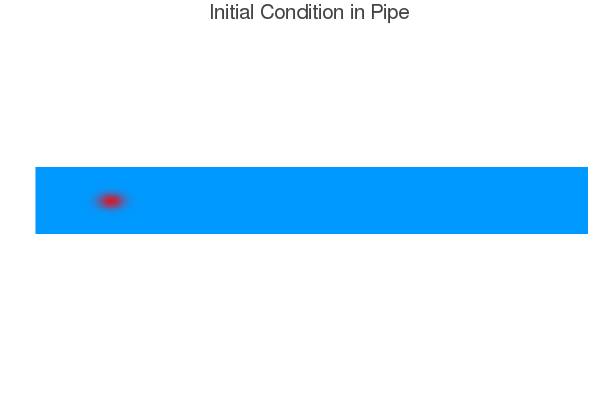

In [103]:
n = 100;
v(y)=1 - (y/w)^2;
@gif for i in range(0, stop = 5, length = 40)
    fstep(x, y) = (1/(sqrt(1+ν0^2*i)))*f((x-7*i*v(y) + .75*l)/sqrt(1+ν0^2*i), y/sqrt(1+ν0^2*i))*exp(-(2.6*y/sqrt(1+ν0^2*i))^2/4)
    p = plot(x, y, fstep, st = :heatmap, title="Initial Condition in Pipe", c=cgrad([RGB(0,.6,1),:red]),grid=false,  xaxis = false, yaxis=false, aspect_ratio = 0.75,  clims=(0, 0.15))
end

## Defining model ODEs 
Next let's proceed by defining our system of ODEs. We'll set $N=8$, indicating 8 corrective terms to the effective behavior.

In [50]:
N = 8;
@parameters t       
@variables α[collect(0:N)](t) β[collect(0:N)](t)
D = Differential(t)
eqs =[];
push!(eqs, D(α[1]) ~ 0);
push!(eqs, D(β[1]) ~ (1/2)* β[1] - (exp(t))*β[1]);
push!(eqs, D(α[2]) ~ -(1/2)*α[2] - β[1]);
push!(eqs, D(β[2]) ~ -(exp(t))*(β[2] + α[1]));
for k=3:(N+1)
    push!(eqs, D(α[k]) ~ -(k/2)*α[k]-β[k-1] - α[k-2]);
    push!(eqs, D(β[k]) ~ (-k/2 + 1/2)*β[k] - β[k-2] - (exp(t))*(β[k] + α[k-1]));
end

## Passing inputs to Mathematica
Next we'll pass some information about the initial conditions to a Mathematica script, which will calculate the integrals needed to feed the correct initial values to our system:

In [51]:
numEqs = N+1;
mults = [(1+ν0^2)^k for k=0:N];
weval(W```
<< "generate_ics";
testFunc = randFunParam[sca,shi,coeffs,nu];
Export["ics_test.csv",{a[testFunc, numEqs, xMax], b[testFunc, numEqs, xMax]}];
```; sca= adjRandScale, shi=adjRandShift, coeffs=randOffst, nu=ν0, xMax=XMax, numEqs=numEqs)
ics=readdlm("ics_test.csv", ',', Float64, '\n');
icsScaled=ics.*mults';

In [52]:
u0 = reshape(icsScaled, (1, 2*numEqs));
#p = [ν => 0.1];
sys = ODESystem(eqs);

## Solving and Plotting our system
Now that we have our initial conditions set, we'll solve and plot our system:

In [53]:
tspan = (0.0,4*TMax)
prob = ODEProblem(sys,u0,tspan,jac=true)
sol = solve(prob,Tsit5());

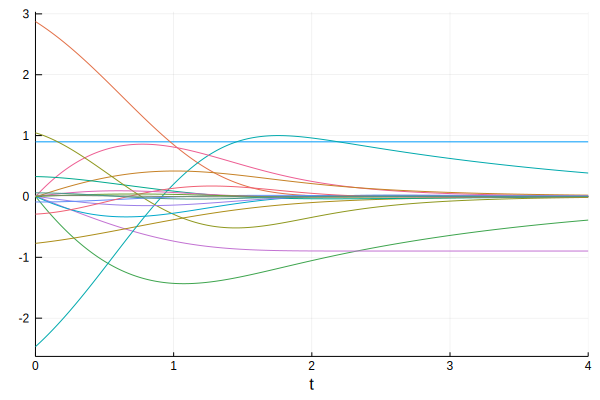

In [54]:
plot(sol, legend=false)

## Results in original domain
Now we have solved our system over the intended timescale, but we'd like to see what the results look like in the original fluid domain:

┌ Info: Saved animation to 
│   fn = C:\Users\illes\code\tmp.gif
└ @ Plots C:\Users\illes\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\illes\\code\\tmp.gif")
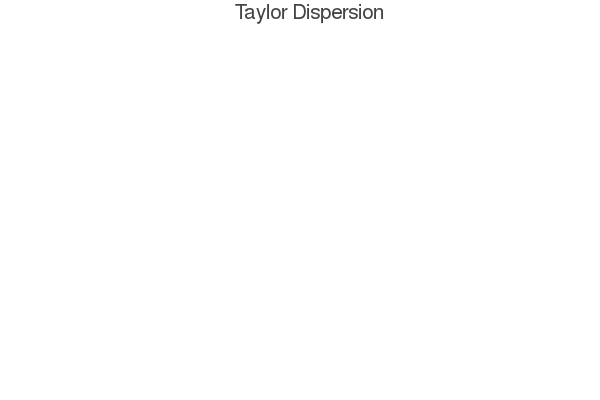

In [104]:
n=length(times);
@gif for i in 1:n
    #F(x,y) = (1/sqrt(4*pi*(log(1+times[i]))))*sum(sol[j,i]*hermTab[(j+1)÷2](ν0*x/sqrt(log(1+times[i])))*exp(-(ν0*x/sqrt(log(1+times[i])))^2/4) for j=1:2:2*numEqs) + (1/(4*pi*(log(1+times[i]))))*sum(sol[j,i]*hermTab[j÷2](ν0*x/sqrt(log(1+times[i])))*exp(-(ν0*x/sqrt(log(1+times[i])))^2/4) for j=2:2:2*numEqs)*cos(y);
    G(x,y) = (1/sqrt(4*pi*(log(1+times[i]))))*sum(sol[j,i]*hermTab[(j+1)÷2](x/sqrt(log(1+times[i])))*exp(-(x/sqrt(log(1+times[i])))^2/4) for j=1:2:2*numEqs) + (1/(4*pi*(log(1+times[i]))))*sum(sol[j,i]*hermTab[j÷2](x/sqrt(log(1+times[i])))*exp(-(x/sqrt(log(1+times[i])))^2/4) for j=2:2:2*numEqs)*cos(y);
    F(x,y) = G(ν0*x+.5*times[i],y)
    p = plot(x, y, F, st = :heatmap, title="Taylor Dispersion", c=cgrad([RGB(0,.6,1),:red]),grid=false,  xaxis = false, yaxis=false, aspect_ratio = 0.75,  clims=(0, .5))
end

## What's happening here? Center Manifolds

One can prove that the system of ODEs solved in this notebook has attracting finite-dimensional Center Manifolds which correspond to the enhanced diffusion (Taylor Dispersion) and a fixed number of corrective terms. Here is a visualization of (slightly slowed down) Taylor Dispersion alongside a Phase Space visualization of the solution and a Center Manifold:

<center><img src="cm_simul.gif"></center>